In [1]:
using CSV, DataFrames, Dates, Plots, DiffEqFlux, DifferentialEquations.OrdinaryDiffEq, Optim, Random; include("AuxMisc.jl")

In [2]:
df = DataFrame(CSV.File("DadosMedia.csv"))

datasTudo = df[:, "DatasMedia"]
infTudo = df[:, "InfectadosMedia"]
recTudo = df[:, "RecuperadosMedia"]
decTudo = df[:, "ObitosMedia"]

limiteE = findall(data -> data == Date(2020, 03, 18), datasTudo)[1]
limiteD = findall(data -> data == Date(2020, 06, 30), datasTudo)[1]

datasOnda = datasTudo[limiteE:limiteD]
infOnda = infTudo[limiteE:limiteD]
recOnda = recTudo[limiteE:limiteD]
decOnda = decTudo[limiteE:limiteD]

dadosOnda = hcat(infOnda, recOnda, decOnda)

u₀_SIRD  = [infOnda[1], recOnda[1], decOnda[1]]
θ_ext₀_SIRD = [50_000, 0.5, 0.5, 0.5]

nothing

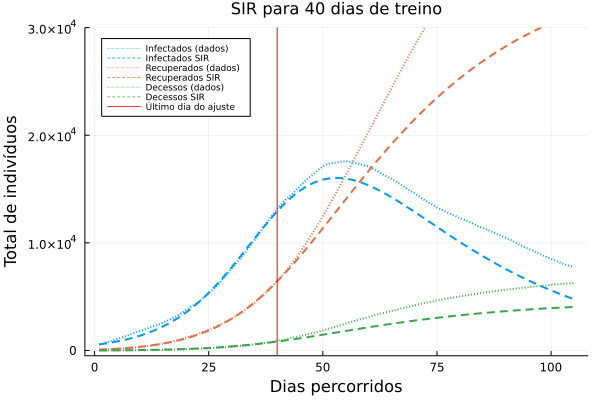

In [3]:
N = 40

function φ(x)
    return max(0, min(x, 1))
end

function dudtSIR!(du, u, θ, t)
    S, I, R, D = u
    N = S + I + R + D
    #N = S + I + R
    β, γ_R, γ_D = θ

    E_novos = β^2 * I*S / N
    dS = -E_novos 
    dI = E_novos - (γ_R^2 + γ_D^2)*I
    dR = γ_R^2*I
    dD = γ_D^2*I

    du[1] = dS; du[2] = dI; du[3] = dR; du[4] = dD
end

u₀ = u₀_SIRD
θ_ext₀_SIR = θ_ext₀_SIRD
indModelo = [2, 3, 4]
iterSIR = 10^4

dadosTreino = dadosOnda[1:N, :]    
dadosTreinoT = dadosTreino'

#fatores = [1 1 1]
#fatores = [1 5 5]
#fatorInf = 1/sum(dadosTreinoT[1, :]); fatorRec = 1/sum(dadosTreinoT[2, :]); fatorDec = 1/sum(dadosTreinoT[3, :])
#fatorInf = 1/sum(abs2, dadosTreinoT[1, :]); fatorRec = 1/sum(abs2, dadosTreinoT[2, :]); fatorDec = 1/sum(abs2, dadosTreinoT[3, :])
fatorInf = 1/maximum(dadosTreinoT[1, :]); fatorRec = 1/maximum(dadosTreinoT[2, :]); fatorDec = 1/maximum(dadosTreinoT[3, :])
fatores = [fatorInf fatorRec fatorDec]
fatores = fatores / sqrt(sum(abs2, fatores))
#@show fatores

# AJUSTE SIR:    
modeloSIR(θ_ext) = solve(ODEProblem(dudtSIR!, [θ_ext[1]; u₀], (1., N), θ_ext[2:end]), saveat = 1)[indModelo, :]

custoSIR(θ_ext) = sum(fatores * (dadosTreinoT .- modeloSIR(θ_ext)) .^2)
#custoSIR(θ_ext) = sum(abs, (dadosTreinoT[:, 2:end] .- modeloSIR(θ_ext)[:, 2:end]) ./ dadosTreinoT[:, 2:end])
#custoSIR(θ_ext) = sum((dadosTreinoT[:, 2:end] .- modeloSIR(θ_ext)[:, 2:end]).^2 ./ dadosTreinoT[:, 2:end].^2)

θ_ext₁_SIR = Optim.minimizer(optimize(custoSIR, θ_ext₀_SIR, iterations = iterSIR))
S₀_SIR = θ_ext₁_SIR[1]
θ₁_SIR = θ_ext₁_SIR[2:end]

resultSIR = solve(ODEProblem(dudtSIR!, [S₀_SIR; u₀], (1., size(dadosOnda)[1]), θ₁_SIR), saveat = 1)

infSIR = resultSIR[indModelo[1], :]
recSIR = resultSIR[indModelo[2], :]
decSIR = resultSIR[indModelo[3], :]

pl = plot(infOnda, label = "Infectados (dados)", lw = 2, color = 1, linestyle = :dot)
plot!(pl, infSIR, label = "Infectados SIR", lw = 2, color = 1, linestyle = :dash)

plot!(pl, recOnda, label = "Recuperados (dados)", lw = 2, color = 2, linestyle = :dot)
plot!(pl, recSIR, label = "Recuperados SIR", lw = 2, color = 2, linestyle = :dash)

plot!(pl, decOnda, label = "Decessos (dados)", lw = 2, color = 3, linestyle = :dot)
plot!(pl, decSIR, label = "Decessos SIR", lw = 2, color = 3, linestyle = :dash)

plot!(pl, [N], seriestype = "vline", label = "Último dia do ajuste", color = "red")

plot!(pl, title = "SIR para $N dias de treino", titlefont = 11 , ylim = (-500, 30000),
    xlabel = "Dias percorridos", ylabel = "Total de indivíduos", legend = :topleft, legendfont = 6)

cost_name = "SSR-max"

CSV.write(string("parametros/condicao_inicial_SIRD_", cost_name, "_", N, "_dias.csv"), DataFrame(permutedims([S₀_SIR]), :auto),
    header = false)
CSV.write(string("parametros/parametros_SIRD_", cost_name, "_", N, "_dias.csv"), DataFrame(permutedims(θ₁_SIR), :auto), header = false)

display(pl)

In [4]:
fatorReducao = sum([S₀_SIR; u₀])
dadosTreinoT = dadosTreinoT ./ fatorReducao
u₀ = u₀ ./ fatorReducao
S₀_SIR = S₀_SIR / fatorReducao

0.9850348640993369

In [5]:
function ajusteUODE()
    NN = FastChain(FastDense(4,16,tanh), FastDense(16,16,tanh), FastDense(16,1), (x, θ) -> x.^2)
    inputVectorSizeNN = 4
    
    numDataPoints = 1_000
    Xs = rand(inputVectorSizeNN, numDataPoints)

    func(X) = θ₁_SIR[1]^2

    data_func = [func(X) for X in eachcol(Xs)]

    function costNN(θ)
        pred = [NN(X, θ)[1] for X in eachcol(Xs)]
        return sum(abs2, data_func .- pred), pred
    end

    function callBackNN(θ, cost, pred)
        return false
    end

    resultBFGS = DiffEqFlux.sciml_train(costNN, initial_params(NN), cb = callBackNN, BFGS(initial_stepnorm = 0.01),
        maxiters = 1_000, allow_f_increases = true)
    θ₀_NN = resultBFGS.minimizer

    UODE_optim_failed = 0
    
    function dudtUODE!(du, u, θ, t)
        S, I, R, D = u
        N = S + I + R + D
        γ_R, γ_D = θ[1:2]

        E_novos =  NN(u, θ[3:end])[1] * I*S / N
        dS = -E_novos 
        dI = E_novos - (γ_R^2 + γ_D^2)*I
        dR = γ_R^2*I
        dD = γ_D^2*I

        du[1] = dS; du[2] = dI; du[3] = dR; du[4] = dD
    end

    θ₀_UODE = [θ₁_SIR[2:end]; θ₀_NN]
    
    problemaUODE = ODEProblem(dudtUODE!, [S₀_SIR; u₀], (1.,N), θ₀_UODE)

    function custoUODE(θ)
        previsao = concrete_solve(problemaUODE, Vern7(), [S₀_SIR; u₀], θ, saveat = 1, abstol = 1e-4, reltol = 1e-4,
            sensealg = InterpolatingAdjoint(autojacvec = ReverseDiffVJP()))[indModelo, :]
        #if length(previsao[1, :]) == N
            custo = sum(fatores * (dadosTreinoT .- previsao) .^2)
            #custo = sum(abs, (dadosTreinoT[:, 2:end] .- previsao[:, 2:end]) ./ dadosTreinoT[:, 2:end])
            #custo = sum((dadosTreinoT[:, 2:end] .- previsao[:, 2:end]).^2 ./ dadosTreinoT[:, 2:end].^2)
            return custo, previsao
        #end
        #return 10^10, previsao
    end

    function callBackUODE(θ, custo, previsao)
        #if length(previsao[1, :]) == N
            return false
        #end
        #UODE_optim_failed = 1
        #Flux.stop()
    end

    resultadoBFGS_UODE = DiffEqFlux.sciml_train(custoUODE, θ₀_UODE, cb = callBackUODE, BFGS(initial_stepnorm = 0.01),
        maxiters = 250, allow_f_increases = true)
    
    if UODE_optim_failed == 1
        return 0
    end
    
    θ₁_UODE = resultadoBFGS_UODE

    modeloUODE = solve(ODEProblem(dudtUODE!, [S₀_SIR; u₀], (1., size(dadosOnda)[1]), θ₁_UODE), saveat = 1)[indModelo, :]' .* fatorReducao

    infUODE = modeloUODE[:, 1]
    recUODE = modeloUODE[:, 2]
    decUODE = modeloUODE[:, 3]

    pl = plot(infOnda, label = "Infectados (dados)", lw = 2, color = 1, linestyle = :dot)
    plot!(pl, infSIR, label = "Infectados SIR", lw = 2, color = 1, linestyle = :dash)
    plot!(pl, infUODE, label = string("Infectados UODE"), lw = 2, color = 1)

    plot!(pl, recOnda, label = "Recuperados (dados)", lw = 2, color = 2, linestyle = :dot)
    plot!(pl, recSIR, label = "Recuperados SIR", lw = 2, color = 2, linestyle = :dash)
    plot!(pl, recUODE, label = string("Recuperados UODE"), lw = 2, color = 2)

    plot!(pl, decOnda, label = "Decessos (dados)", lw = 2, color = 3, linestyle = :dot)
    plot!(pl, decSIR, label = "Decessos SIR", lw = 2, color = 3, linestyle = :dash)
    plot!(pl, decUODE, label = string("Decessos UODE"), lw = 2, color = 3)

    plot!(pl, [N], seriestype = "vline", label = "Último dia do ajuste", color = "red")

    plot!(pl, title = string("UODE x SIR para $N dias de treino [custo = ", cost_name, "]"),  titlefont = 11 , ylim = (-500, 50000),
        xlabel = "Dias percorridos", ylabel = "Total de indivíduos", legend = :topleft, legendfont = 6)

    display(pl)

    return θ₁_UODE

end

ajusteUODE (generic function with 1 method)

In [ ]:
UODE_model_name = "SIRD_UODE_b"

csv_file_name = string("parametros/parametros_", UODE_model_name, "_", cost_name, "_amostral_", N, "_dias.csv")

r = ajusteUODE()

if r != 0
    θ₁_UODE = r
    CSV.write(csv_file_name, DataFrame(permutedims(θ₁_UODE), :auto), append = true)
end

In [ ]:
df = CSV.read(csv_file_name, DataFrame, header = false)

while length(df[:, 1]) < 25
    r = ajusteUODE()
    
    if r == 0
        println("Optimization failed.")
    end
    
    if r != 0
        θ₁_UODE = r
        CSV.write(csv_file_name, DataFrame(permutedims(θ₁_UODE), :auto), append = true)
        df = CSV.read(csv_file_name, DataFrame, header = false)
    end
end